In [9]:
import pandas as pd
import numpy as np

from itertools import combinations

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# visualizations
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# model training
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Scaling

In the last session, we left scaling out. Let us first see how scaling some of the features can help us with achieving a better performance (or if it can help at all).

In [10]:
train = pd.read_csv(r"D:\Repositories\Git_GitHub\data-science-track\data-science-track\03-machine-learning\resources\data_preprocessing_2\train_encoded_wo_outliers.csv")
test = pd.read_csv(r"D:\Repositories\Git_GitHub\data-science-track\data-science-track\03-machine-learning\resources\data_preprocessing_2\test_encoded_wo_outliers.csv")

print(train.shape)
print(test.shape)
train.head(2)

(17544, 14)
(3096, 14)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-118.40,33.90,37.0,2458.0,400.0,920.0,375.0,7.8924,500001.0,1,0,0,0,0
1,-117.66,34.09,23.0,1426.0,313.0,954.0,319.0,3.0357,151500.0,0,1,0,0,0


# Standard Scaling

In [11]:
def scaling_features(train, test, columns, scaling_type):

  for col in columns:

    if scaling_type == 'standard':
      scaler = StandardScaler()
    elif scaling_type == 'min-max':
      scaler = MinMaxScaler()
    else:
      raise ValueError(f'scaling_type "{scaling_type}" does not exist.')

    serie_train = train[col].values.reshape(-1, 1)
    train[col] = scaler.fit_transform(serie_train)
    serie_test = test[col].values.reshape(-1, 1)
    # Very important: You must always fit your scaler on the train part of the
    # feature, and use the fitted scaler to only transform the test part.
    # You should NEVER fit_transform on your test dataset
    test[col] = scaler.transform(serie_test)

  return train, test

In [12]:
columns_to_scale = ['total_rooms',
                    'total_bedrooms',
                    'population',
                    'households']

train_scaled, test_scaled = scaling_features(train.copy(), test.copy(), columns_to_scale, 'standard')

In [13]:
train_scaled.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-118.4,33.9,37.0,-0.007842,-0.357158,-0.53959,-0.355279,7.8924,500001.0,1,0,0,0,0


In [14]:
train_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17544.000000,17544.000000,17544.000000,1.754400e+04,1.754400e+04,1.754400e+04,1.754400e+04,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,-119.568136,35.631153,28.584074,-2.980845e-16,-2.430037e-18,-1.526873e-16,1.085416e-16,3.868528,206375.621637,0.442658,0.317373,0.000228,0.110978,0.128762
std,2.002467,2.137925,12.563423,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.898756,114865.887657,0.496715,0.465467,0.015098,0.314114,0.334946
min,-124.300000,32.540000,1.000000,-1.673039e+00,-1.685017e+00,-1.699763e+00,-1.707842e+00,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.790000,33.930000,18.000000,-6.953459e-01,-7.007999e-01,-7.091249e-01,-7.033916e-01,2.563400,119575.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.250000,29.000000,-2.363317e-01,-2.437228e-01,-2.296207e-01,-2.319888e-01,3.531300,179400.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,37.000000,4.565967e-01,4.502337e-01,4.788817e-01,4.751152e-01,4.744375,263900.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,2.561621e+00,2.555457e+00,2.484006e+00,2.516108e+00,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
def fit_evaluate_linear_regression(X_train, y_train, X_test, y_test):
  # initialize the model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)


  # Evaluate the model
  mse_train = mean_squared_error(y_train, y_pred_train)
  mse_test = mean_squared_error(y_test, y_pred_test)
  print("Train MSE:", mse_train)
  print("Test MSE:", mse_test)

  print("Train RMSE:", np.sqrt(mse_train))
  print("Test RMSE:", np.sqrt(mse_test))

  return model.coef_, model.intercept_


def get_model_inputs(train_encoded, test_encoded):
  target_feature = 'median_house_value'
  features = [el for el in train_encoded.columns if el!=target_feature]
  X_train = train_encoded[features].values
  y_train = train_encoded[target_feature].values
  X_test = test_encoded[features].values
  y_test = test_encoded[target_feature].values

  return X_train, y_train, X_test, y_test, features

In [16]:
X_train, y_train, X_test, y_test, features = get_model_inputs(train_scaled, test_scaled)

coefficients, intercept = fit_evaluate_linear_regression(X_train, y_train, X_test, y_test)

Train MSE: 4481969281.888499
Test MSE: 4649922699.96206
Train RMSE: 66947.51139428932
Test RMSE: 68190.34169119598


In [17]:
pd.DataFrame(zip(features, coefficients), columns=['feature', 'coefficient'])

,feature,coefficient
0,longitude,-26168.767241
1,latitude,-25345.539048
2,housing_median_age,1067.891309
3,total_rooms,-12819.873011
4,total_bedrooms,34134.722077
5,population,-52895.026291
6,households,37250.751085
7,median_income,39279.387373
8,ocean_proximity_<1H OCEAN,-16032.002943
9,ocean_proximity_INLAND,-54860.970377


**Results** did not change compared to when we only removed outliers. It is the same test mse. Why?

The idea of standardization is the fact that linear regression model assumes its features have a normal distribution. But after we removed the outliers, they already had more or less a normal distribution. Here it is:



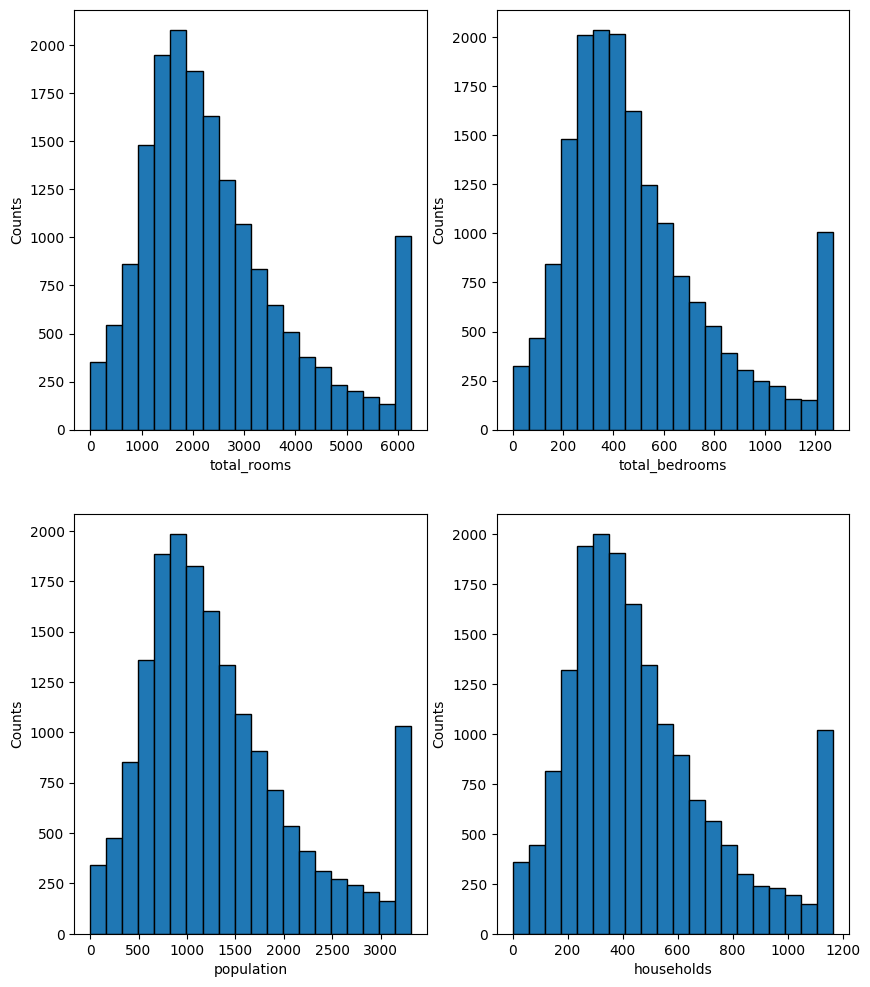

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 12))
axs = axs.flatten()

# Plot histograms for each column
for i, col in enumerate(columns_to_scale):
    axs[i].hist(train[col], bins=20, edgecolor='black')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Counts')

Anyways, standard-scaler is not giving us results.

# Min-Max Scaling

In [19]:
train_scaled, test_scaled = scaling_features(train.copy(), test.copy(), columns_to_scale, 'min-max')

X_train, y_train, X_test, y_test, features = get_model_inputs(train_scaled, test_scaled)
coefficients, intercept = fit_evaluate_linear_regression(X_train, y_train, X_test, y_test)

Train MSE: 4481969281.888499
Test MSE: 4649922699.962061
Train RMSE: 66947.51139428932
Test RMSE: 68190.34169119598


In [20]:
pd.DataFrame(zip(features, coefficients), columns=['feature', 'coefficient'])

,feature,coefficient
0,longitude,-26168.767241
1,latitude,-25345.539048
2,housing_median_age,1067.891309
3,total_rooms,-54287.806486
4,total_bedrooms,144747.417198
5,population,-221300.595851
6,households,157345.294908
7,median_income,39279.387373
8,ocean_proximity_<1H OCEAN,-16032.002943
9,ocean_proximity_INLAND,-54860.970377


Min-Max scaling also did not result in better test-performance!

# Log Scaling

In [21]:
train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,-119.568136,35.631153,28.584074,2469.565641,507.051186,1346.492094,472.976191,3.868528,206375.621637,0.442658,0.317373,0.000228,0.110978,0.128762
std,2.002467,2.137925,12.563423,1474.941945,299.739153,790.422196,275.780564,1.898756,114865.887657,0.496715,0.465467,0.015098,0.314114,0.334946
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.790000,33.930000,18.000000,1444.000000,297.000000,786.000000,279.000000,2.563400,119575.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.250000,29.000000,2121.000000,434.000000,1165.000000,409.000000,3.531300,179400.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,37.000000,3143.000000,642.000000,1725.000000,604.000000,4.744375,263900.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,6247.700000,1273.000000,3309.850000,1166.850000,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
def log_scaling(df, columns):

  for col in columns:
    df[col] = np.log1p(df[col])
  return df

In [23]:
train_scaled = log_scaling(train.copy(), columns_to_scale)
test_scaled = log_scaling(test.copy(), columns_to_scale)

In [24]:
train_scaled.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,-119.568136,35.631153,28.584074,7.609504,6.037112,7.008843,5.968160,3.868528,206375.621637,0.442658,0.317373,0.000228,0.110978,0.128762
std,2.002467,2.137925,12.563423,0.716817,0.691967,0.702915,0.695217,1.898756,114865.887657,0.496715,0.465467,0.015098,0.314114,0.334946
min,-124.300000,32.540000,1.000000,1.098612,1.098612,1.386294,1.098612,0.499900,14999.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-121.790000,33.930000,18.000000,7.275865,5.697093,6.668228,5.634790,2.563400,119575.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.250000,29.000000,7.660114,6.075346,7.061334,6.016157,3.531300,179400.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,37.000000,8.053251,6.466145,7.453562,6.405228,4.744375,263900.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,8.740129,7.149917,8.104960,7.062920,15.000100,500001.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
X_train, y_train, X_test, y_test, features = get_model_inputs(train_scaled, test_scaled)
coefficients, intercept = fit_evaluate_linear_regression(X_train, y_train, X_test, y_test)

Train MSE: 4429688979.739167
Test MSE: 4512964571.804932
Train RMSE: 66555.908676384
Test RMSE: 67178.60203818572


In [26]:
pd.DataFrame(zip(features, coefficients), columns=['feature', 'coefficient'])

,feature,coefficient
0,longitude,-27702.667865
1,latitude,-27176.157837
2,housing_median_age,981.791138
3,total_rooms,-33456.036910
4,total_bedrooms,65648.521603
5,population,-94592.552937
6,households,68702.265090
7,median_income,40513.591661
8,ocean_proximity_<1H OCEAN,-13187.823377
9,ocean_proximity_INLAND,-48717.422687


As you can see, the log transformation is the only transformation which improved the performance of the model. Of the benefits of the log transformation is that it removes the need for handling the outliers.

If we apply the log before handling the outliers, we can even get a better result, further enhancing our claim that log-transformation already takes care of outliers, at least in such cases.

In [30]:
# train_encoded has still outliers in it

train = pd.read_csv(r"D:\Repositories\Git_GitHub\data-science-track\data-science-track\03-machine-learning\resources\data_preprocessing_2\train_encoded.csv")
test = pd.read_csv(r"D:\Repositories\Git_GitHub\data-science-track\data-science-track\03-machine-learning\resources\data_preprocessing_2\test_encoded.csv")

train_scaled = log_scaling(train.copy(), columns_to_scale)
test_scaled = log_scaling(test.copy(), columns_to_scale)

X_train, y_train, X_test, y_test, features = get_model_inputs(train_scaled, test_scaled)
coefficients, intercept = fit_evaluate_linear_regression(X_train, y_train, X_test, y_test)

Train MSE: 4419068286.377058
Test MSE: 4512110181.850707
Train RMSE: 66476.07303667281
Test RMSE: 67172.24264419572


# Income Prediction (Binary classification)


## Census Income Data Set

This data was extracted from the [census bureau](https://www.census.gov/) database. Extraction was done by Ronny Kohavi and Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year or not.

### Attribute Information

- age: continuous.
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- fnlwgt: continuous.
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- education-num: continuous.
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- sex: Female, Male.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- income: >50K, <=50K.

In [32]:
data = pd.read_csv(r'D:\Repositories\Git_GitHub\data-science-track\data-science-track\03-machine-learning\resources\data_preprocessing_2\census_income_data.csv')

print(data.shape)
data.head(3)

(48842, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [33]:
display(data['income'].value_counts())
print('#'*20)
display(data['income'].value_counts(normalize=True))

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

####################


income
<=50K     0.506122
<=50K.    0.254596
>50K      0.160538
>50K.     0.078744
Name: proportion, dtype: float64

In [34]:
0.078744/0.254596, 0.160538/0.506122

(0.3092900124118211, 0.3171922975092962)

We can take the rows whose labels end with '.' as the test dataset. The above calculation shows that the ratio of incomes greather than 50K and less than 50K in both train and test dataset is equal. It is important to make sure the ration of two labels stays the same in both train and test dataset, especially in classification problems.


In [35]:
data['income'].unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

# Train-Test split

In [36]:
train= data.loc[(data['income']==' <=50K') | (data['income']==' >50K')]
test = data.loc[(data['income']==' <=50K.') | (data['income']==' >50K.')]
print(train.shape)
print(test.shape)

print((len(train)+len(test)) == len(data)) # just to check we didn't leave anything out

(32561, 15)
(16281, 15)
True


# EDA

## Variable Identification

In [37]:
train.head(1)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [38]:
num_features = ['age',
                'fnlwgt',
                'education_num',
                'capital_gain',
                'capital_loss',
                'hours_per_week']

cat_features = ['workclass',
                'education',
                'marital_status',
                'occupation',
                'relationship',
                'race',
                'sex',
                'native_country']

In [39]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


**Note**

Although variable 'education_num' is numerical, but it may be also categorical. We have to see if we can find a linear relationship between increasing education_num and the response variable, and if so, we leave as it is, and if not we can consider it as categorical. But in tree-based models, it can stay the way it is. This was more about linear-based models!

## Missing Values

In [40]:
train.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [ ]:
test.isna().sum()

Although missing values sometimes do not show up, then can show up in other ways. For ex. a level from a categorical variable can be denoted as question mark "?" or similarly. We'll be watching for this.

## Drop duplicated values

In [41]:
print(train.shape)
print(train.drop_duplicates().shape)

(32561, 15)
(32537, 15)


As you can see, we have wround 24 duplicated rows. We should ideally drop them.

In [ ]:
train = train.drop_duplicates()
print(train.shape)

# Univariate EDA

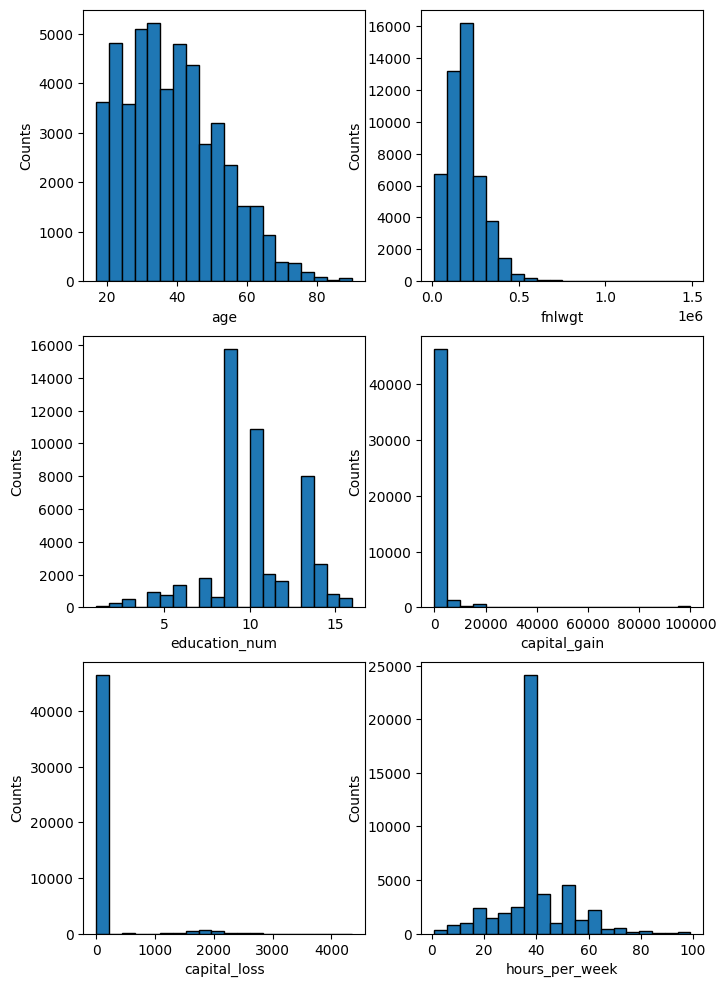

In [42]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12))
axs = axs.flatten()

# Plot histograms for each column
for i, col in enumerate(num_features):
    axs[i].hist(data[col], bins=20, edgecolor='black')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Counts')


Observations:

1. There are some outliers in fnlwgt, capital_gain, capital_loss

2. education_num can be treated as a categorical variable. At least it is worth to try, to see if it brings any improvement.

3. Variables capital_gain and capital_loss have a lot of zeros.

4. 40 hours is the most common hours per week.

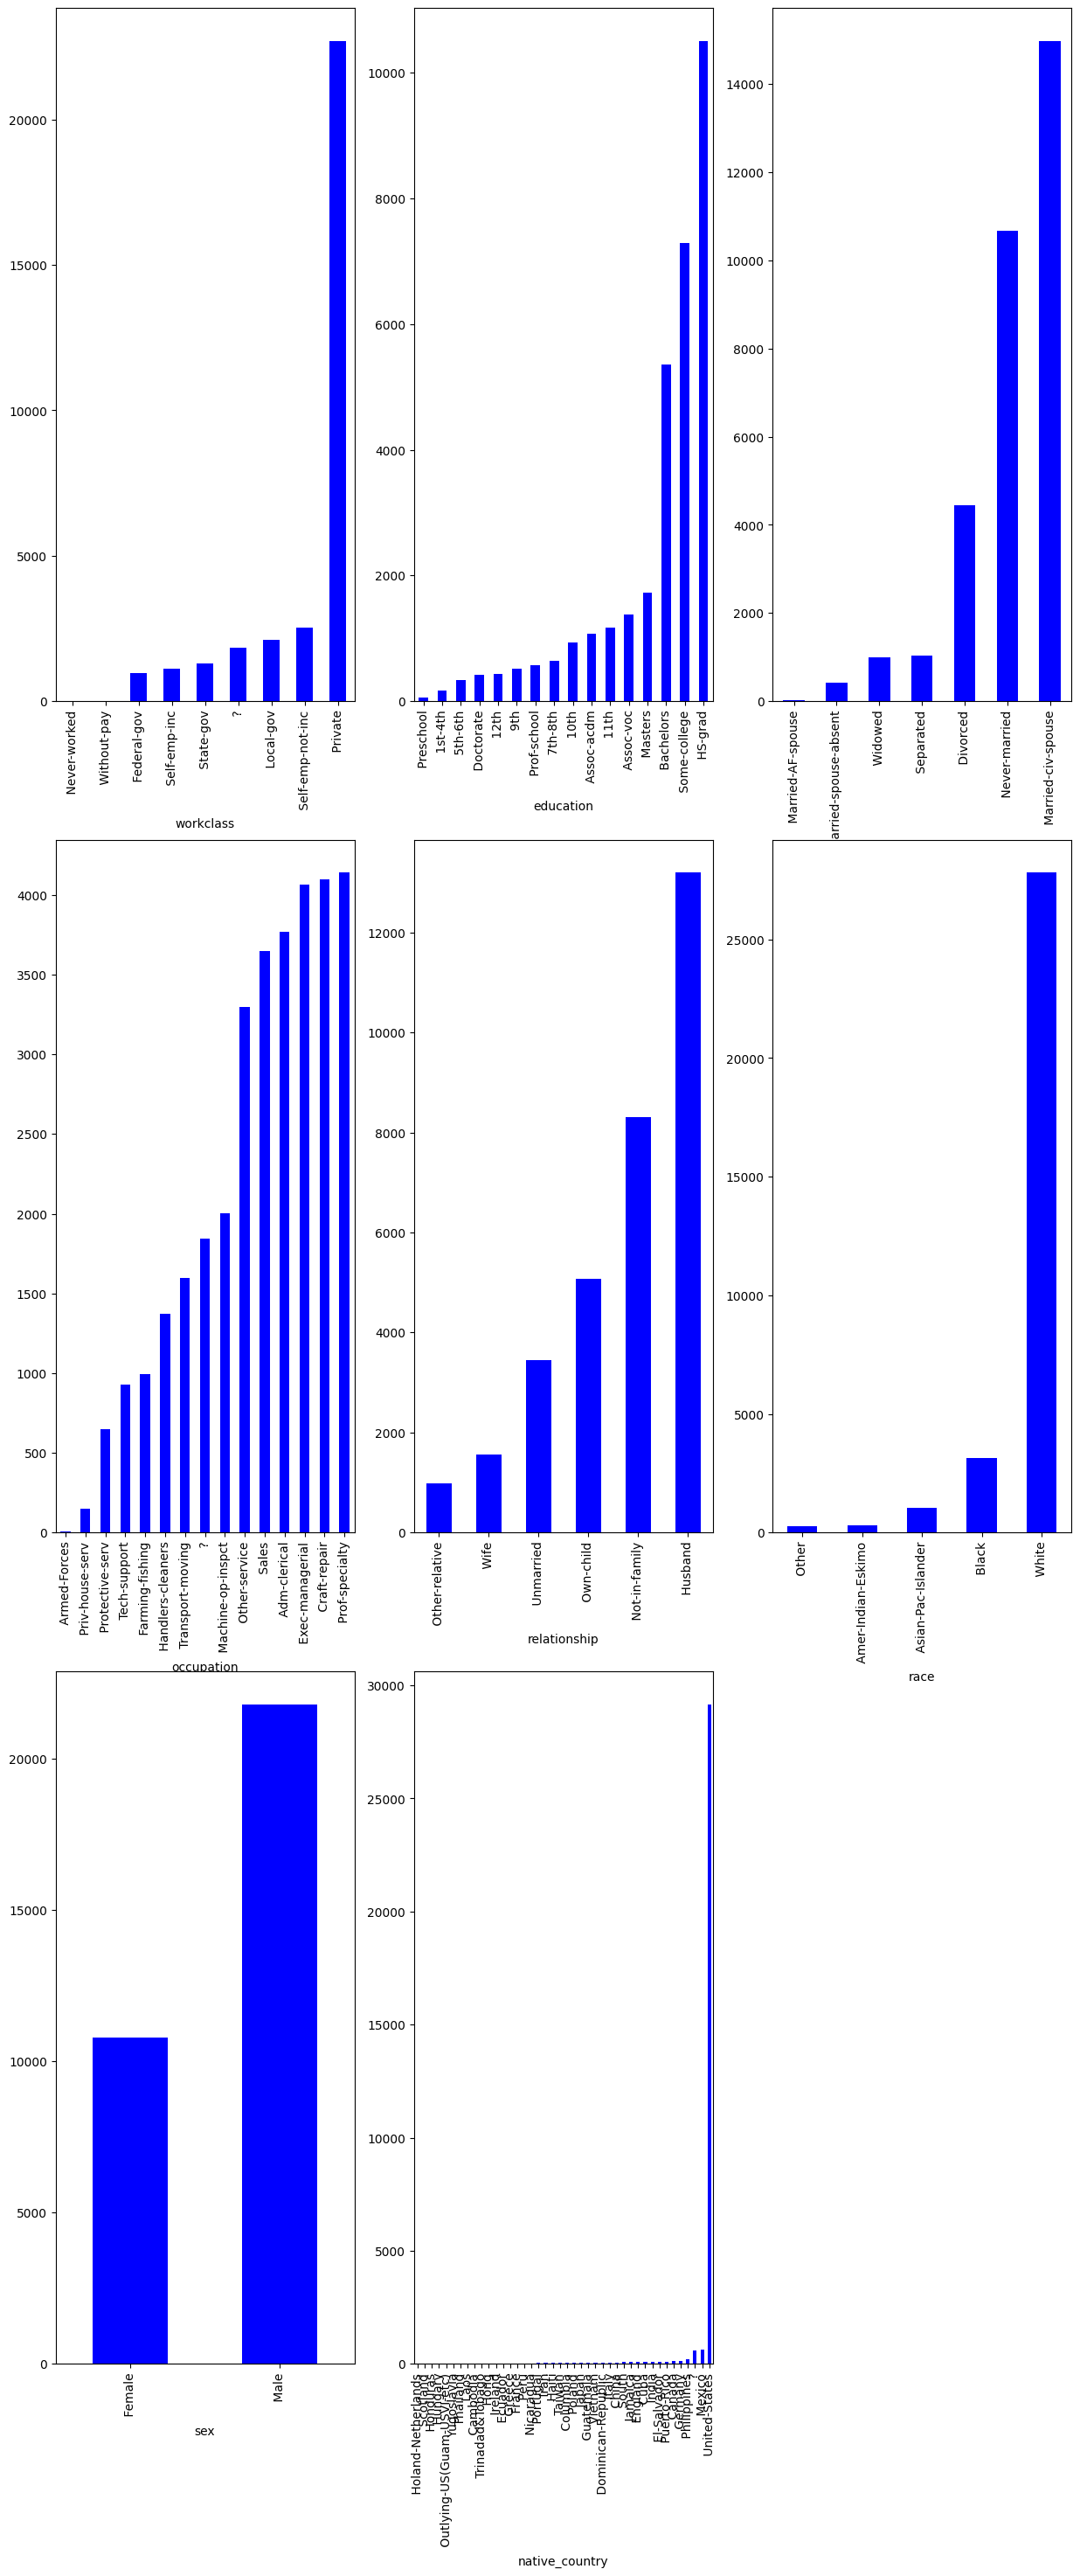

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(15, 35))
axs = axs.flatten()

for i, col in enumerate(cat_features):
  train[col].value_counts(ascending=True).plot(kind='bar', color='blue', ax=axs[i])
  axs[i].set


# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])



# Bivariate EDA

In [45]:
output_dic = {' <=50K': 0, ' >50K': 1}
train.loc[:,'income_encoded'] = train['income'].map(output_dic)
train['income_encoded'].value_counts()

income_encoded
0    24720
1     7841
Name: count, dtype: int64

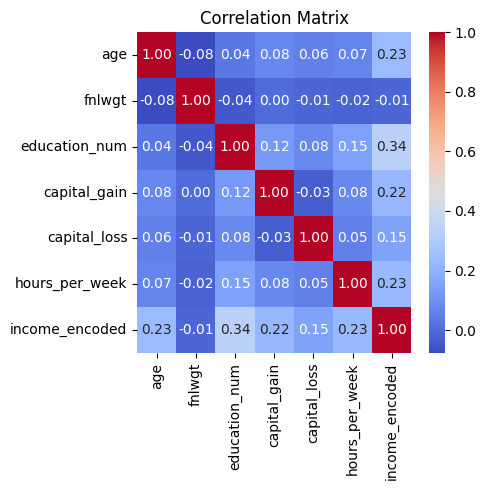

In [46]:
def plotCorrelationMatrix(df, figsize=(5, 5)):

    # Compute the correlation matrix
    corr = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Generate a heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})

    # Set title and adjust layout
    plt.title('Correlation Matrix')
    plt.tight_layout()

    # Show plot
    plt.show()

plotCorrelationMatrix(train[num_features+['income_encoded']])

Observations


1. income has the highest correlation with education_num

2. On the second place, income has the highest correlation with hours_per_week and also age

If we want to do a bi-variate analysis on the categorical features, we must resort to the so-called chi-2 tests. This test is beyond the scope of this course. However, in practice, one does not necessariy need this test!

In [47]:
cat_features

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

We can also resort to a clever approach to measure the correlation between numerical varibles by one-hot encoding them.

workclass


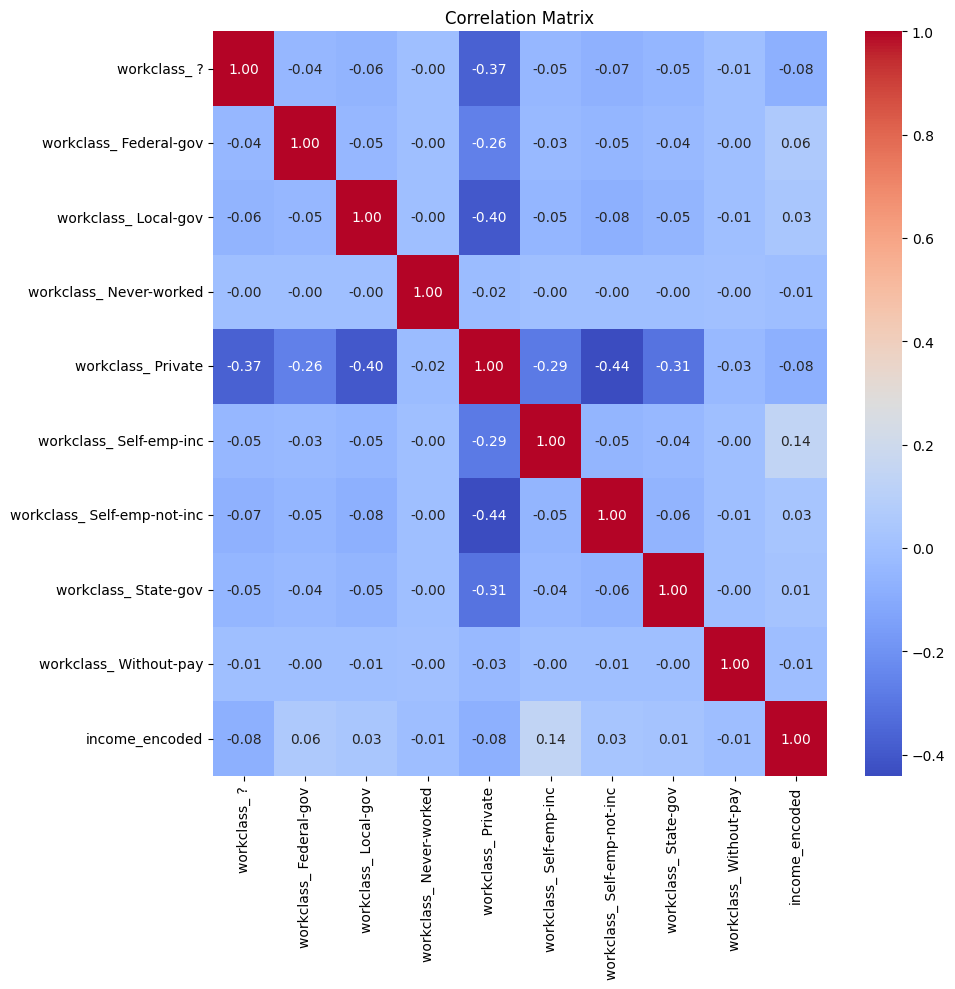

##########
education


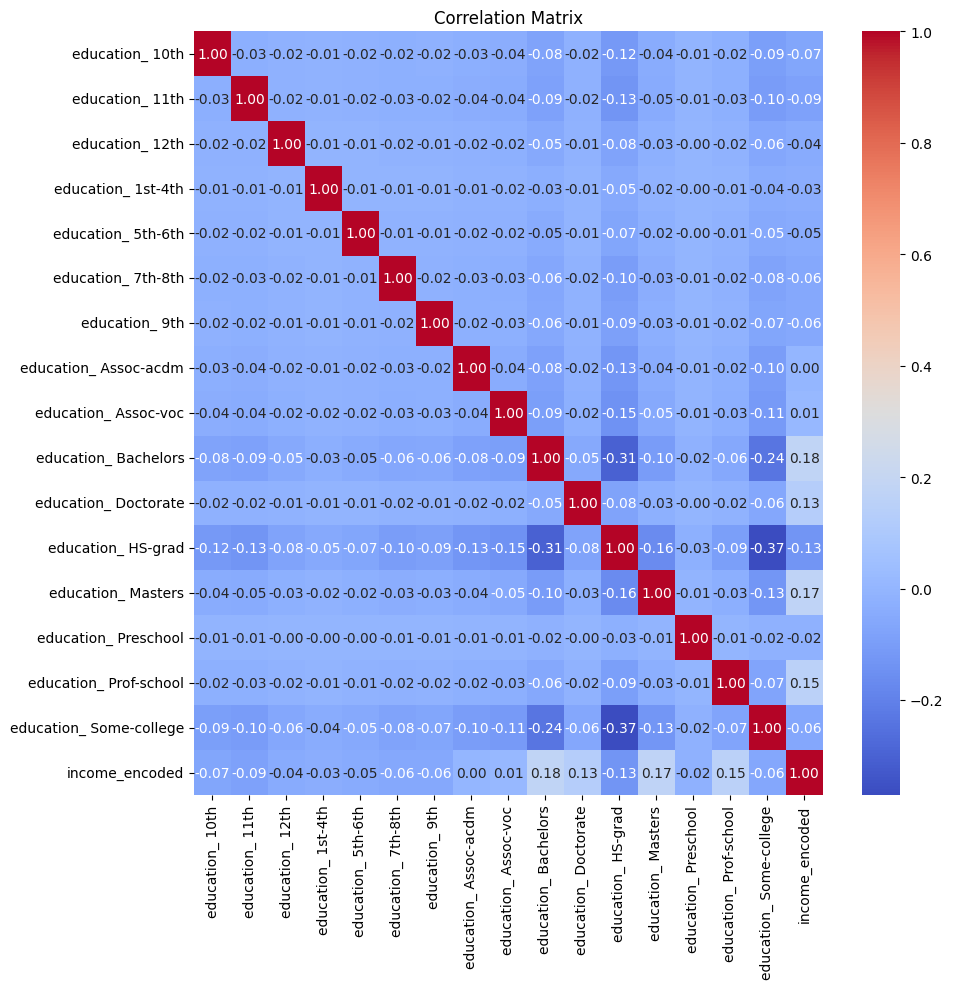

##########
marital_status


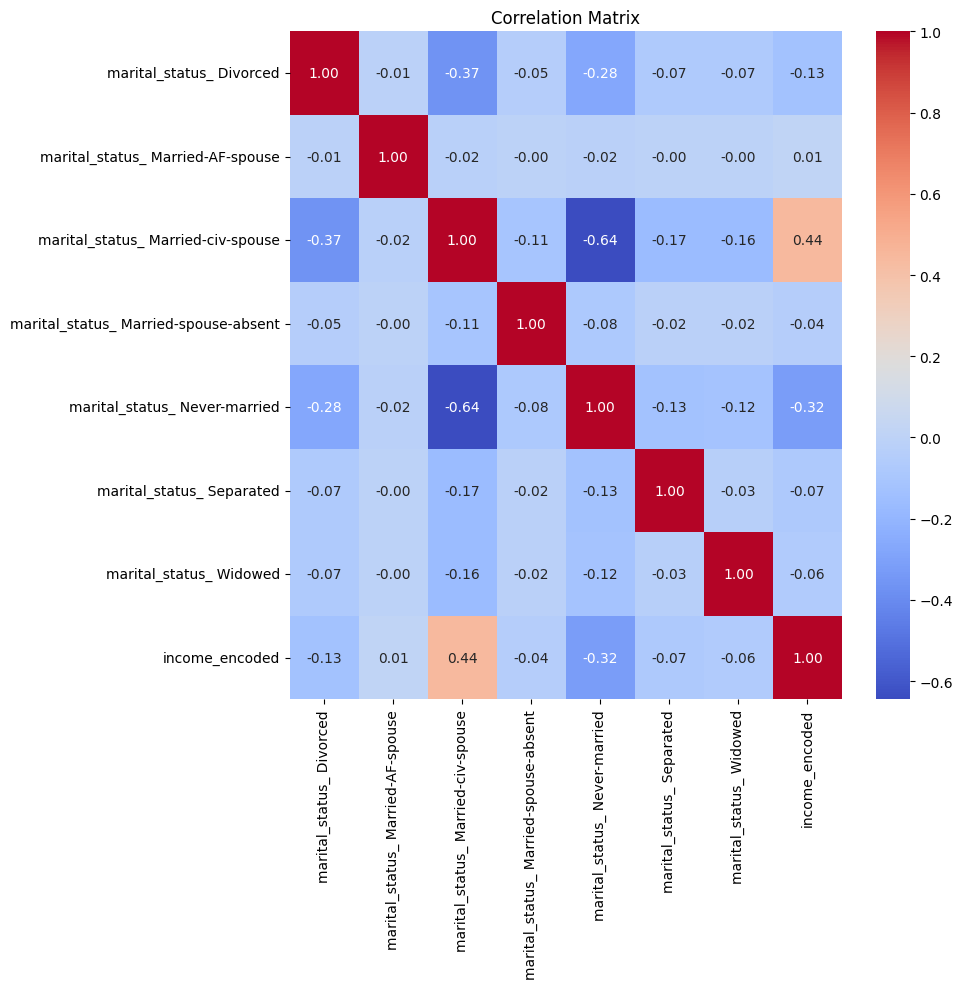

##########
occupation


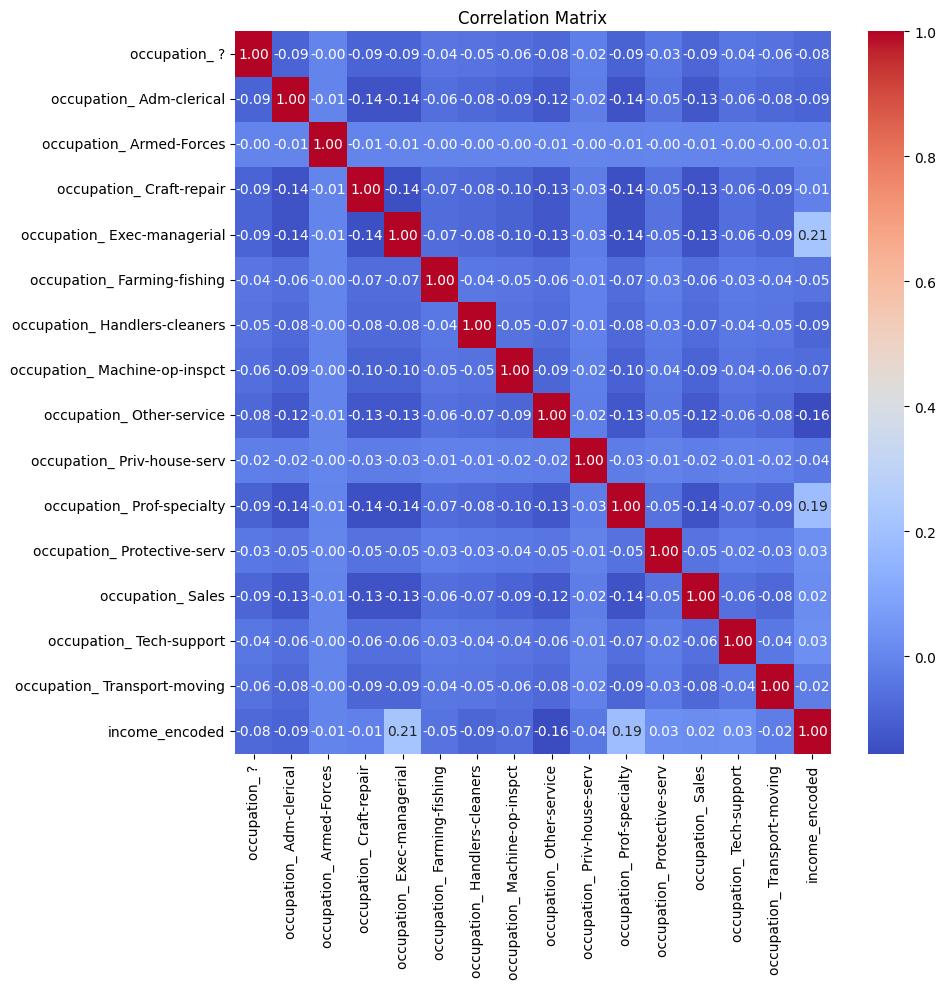

##########
relationship


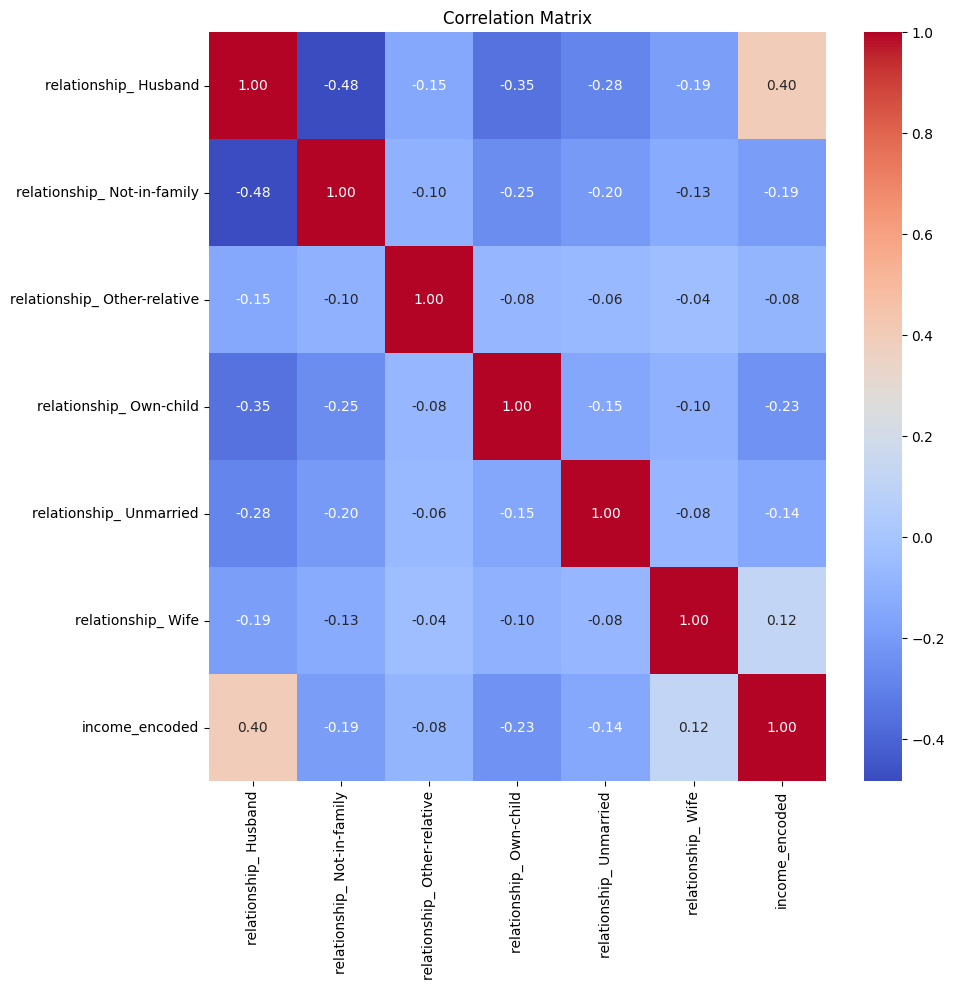

##########
race


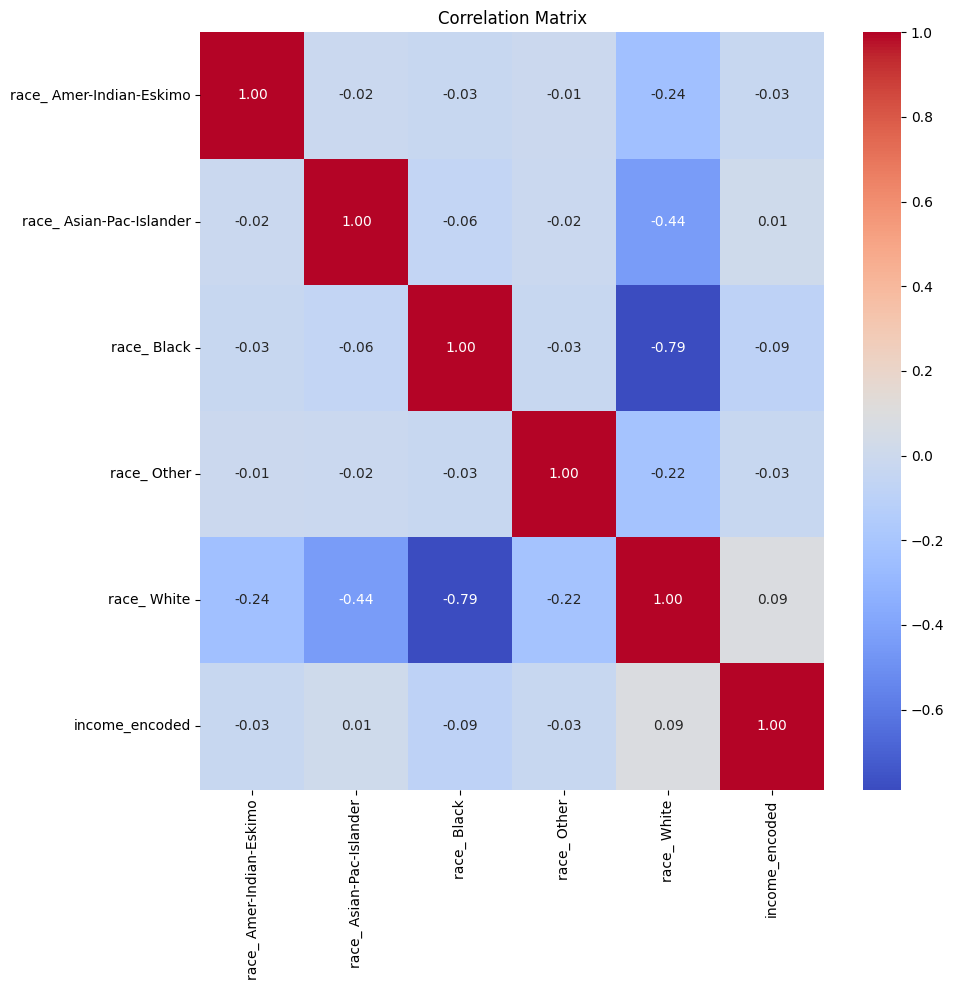

##########
sex


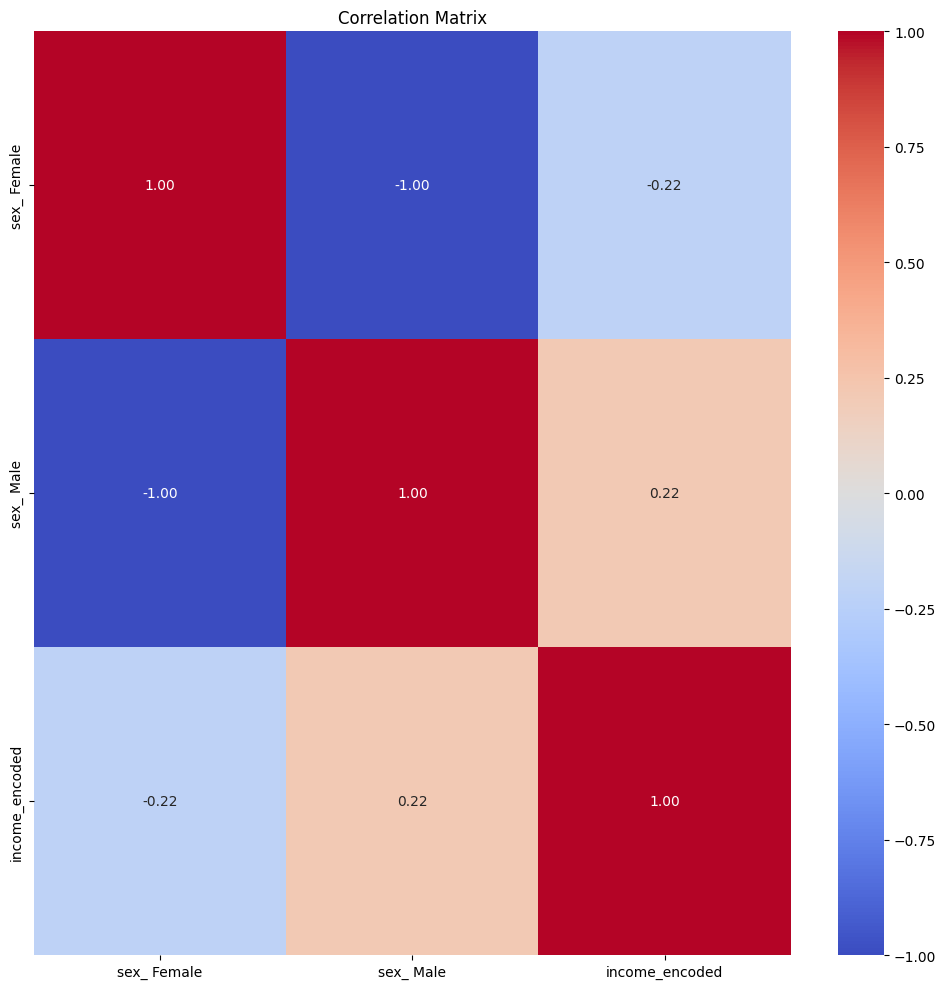

##########


In [48]:
for var in cat_features[:-1]: #excluding native country because it has many levels
  df_temp = pd.get_dummies(train[[var]], columns=[var])
  df_temp = df_temp.apply(lambda row: row.map({True: 1, False: 0}), axis=0)
  #add income_encoded so that we can compare its correlation with other cat features
  df_temp['income_encoded'] = train['income_encoded']
  print(var)
  plotCorrelationMatrix(df_temp, figsize=(10, 10))
  print("#"*10)

native_country


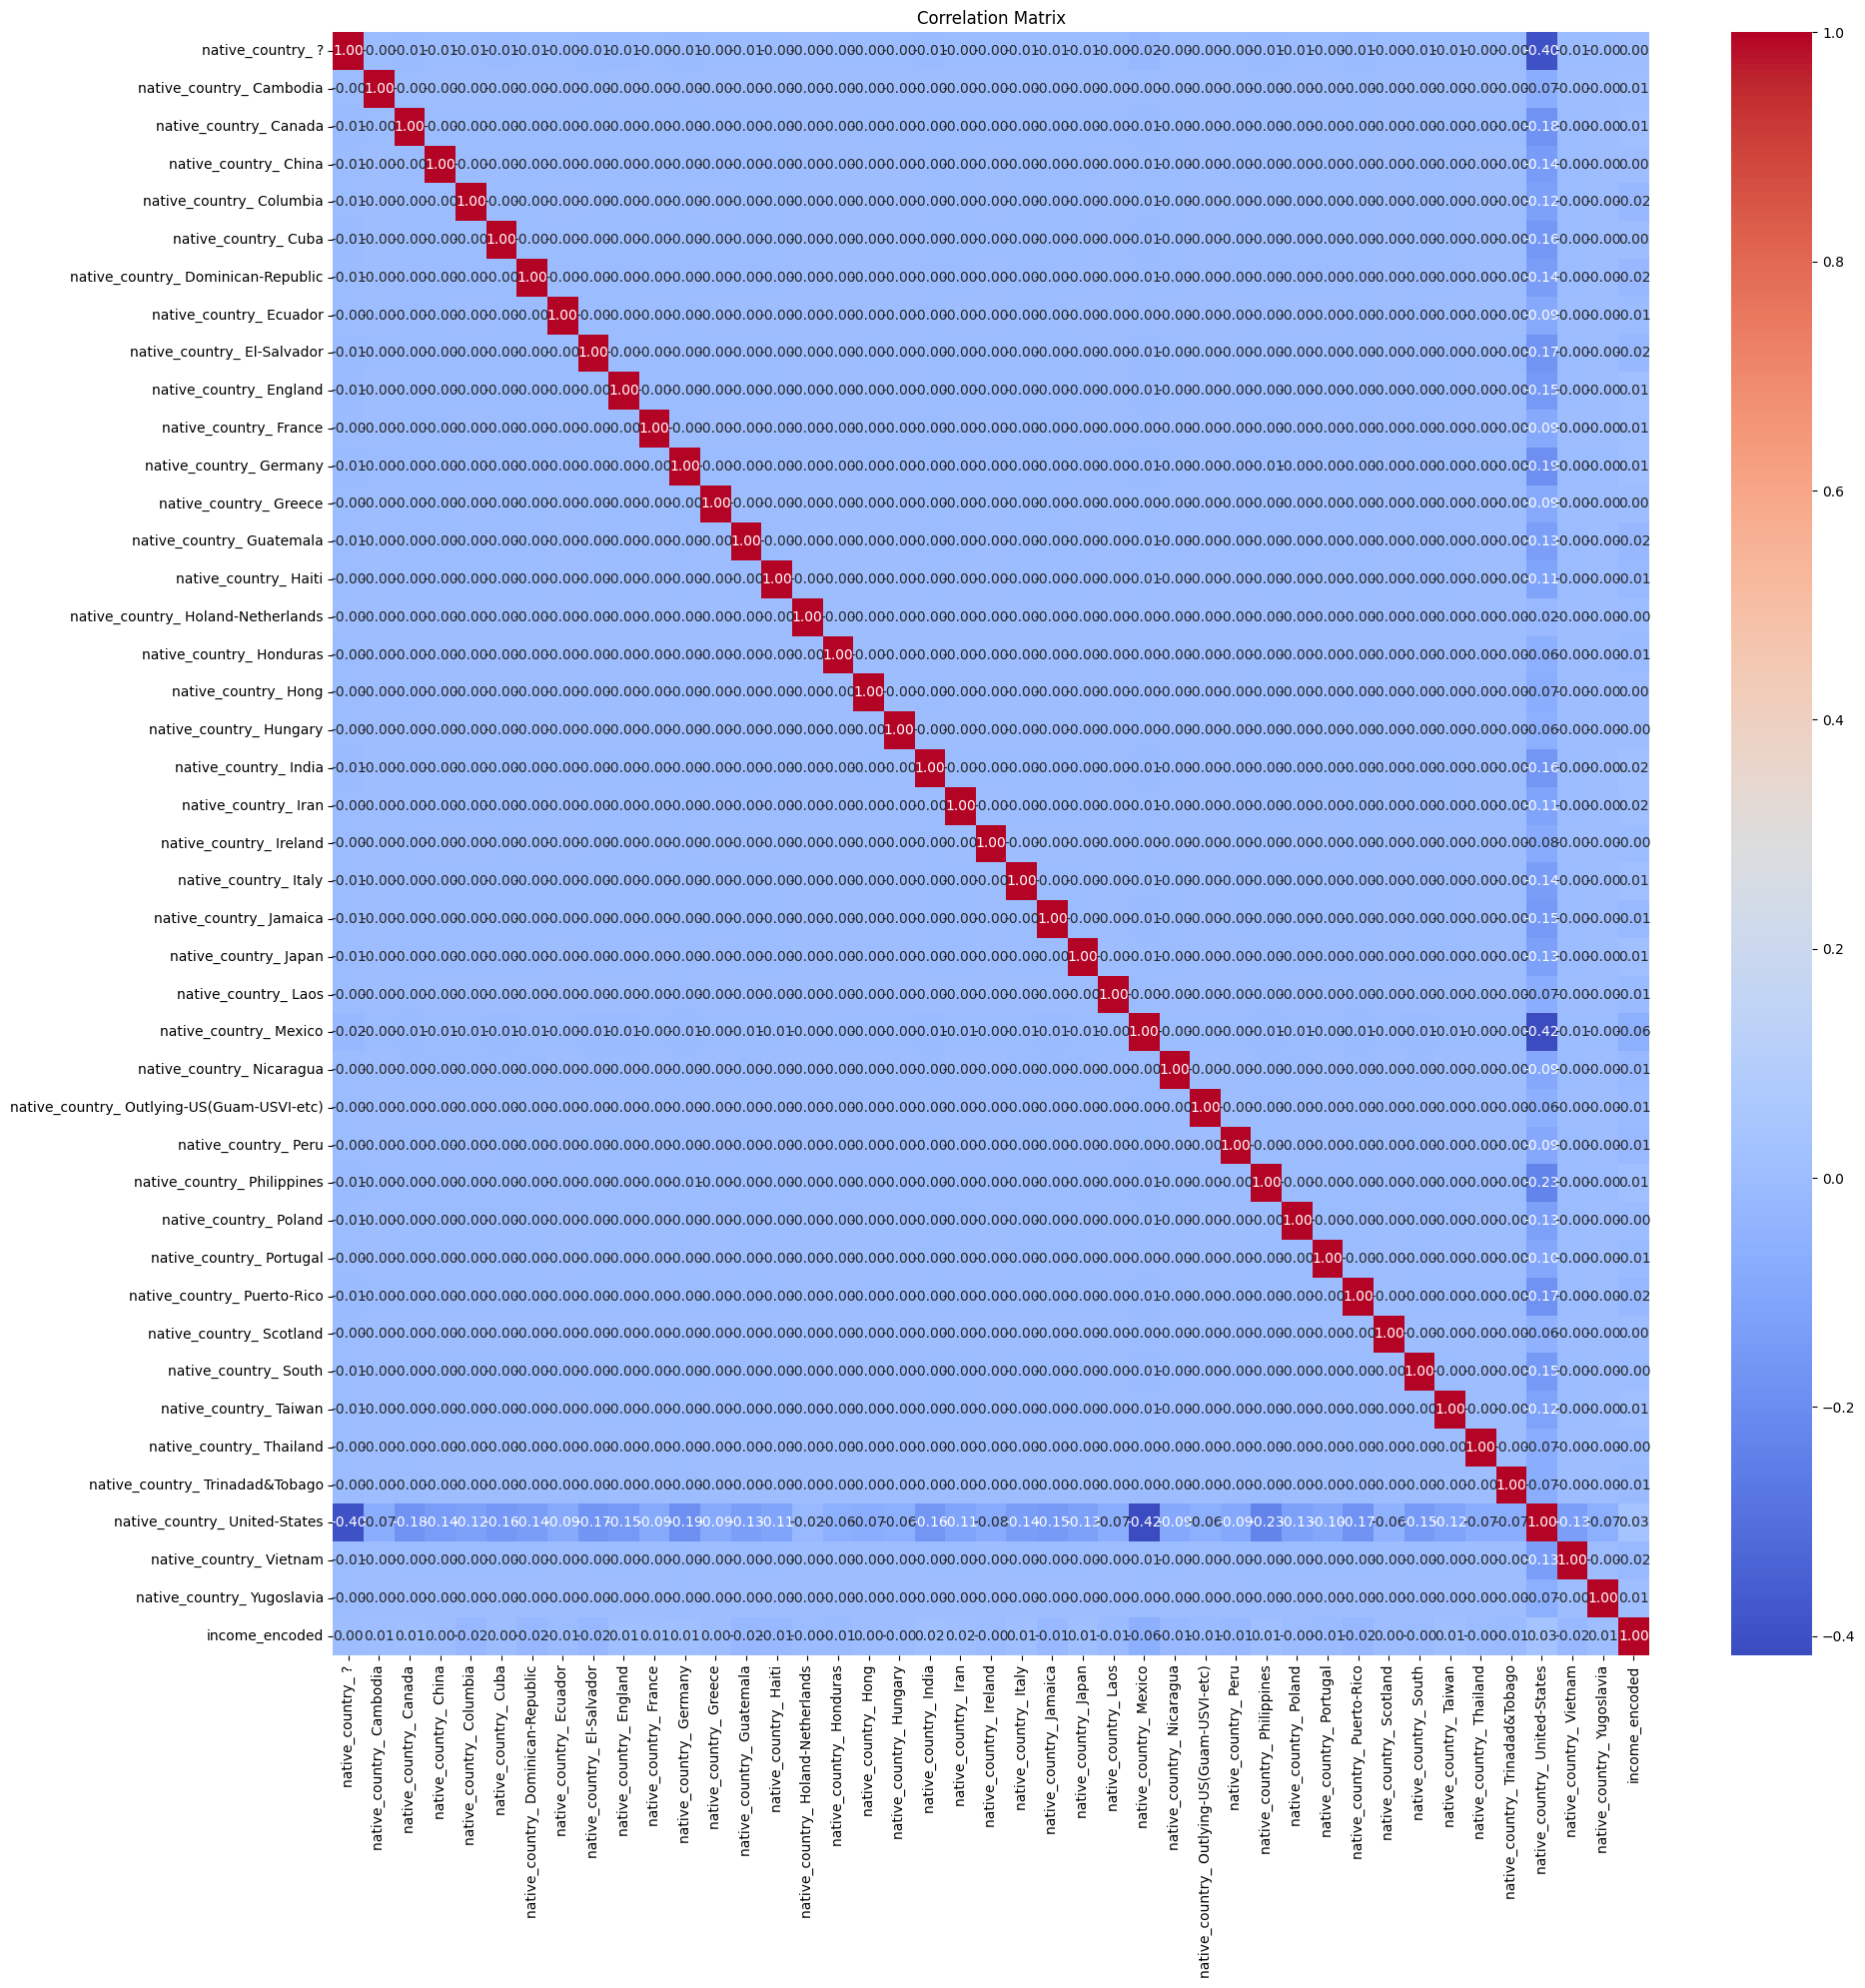

##########


In [49]:
for var in [cat_features[-1]]: # native country
  df_temp = pd.get_dummies(train[[var]], columns=[var])
  df_temp = df_temp.apply(lambda row: row.map({True: 1, False: 0}), axis=0)
  df_temp['income_encoded'] = train['income_encoded']
  print(var)
  plotCorrelationMatrix(df_temp, figsize=(20, 20))
  print("#"*10)

Observations

1. There is not such a strong relationship between native_country and income.

2. Your tasks

In [50]:
cat_features

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

# Fit a model as it is (baseline)

Before performing feature selection or feature engineering, it is good practice
to train a baseline model with the existing features. The purpose of feature engineering and selection is to improve the model, and to determine if we have achieved this improvement on the test dataset, we need a benchmark for comparison.

**NOTE**

The only feature engineering we do on this baseline model is we apply the log transformation on 3 features because their distribution was not so nice as we saw from the univariate analysis.

In [51]:
def prepare_data(data):
  # train test split
  train= data.loc[(data['income']==' <=50K') | (data['income']==' >50K')]
  test = data.loc[(data['income']==' <=50K.') | (data['income']==' >50K.')]

  # dropping duplicates
  train = train.drop_duplicates()
  test = test.drop_duplicates()

  num_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
  cat_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

  # encoding the output
  dic_output = {' <=50K': 0, ' >50K': 1, ' <=50K.': 0, ' >50K.': 1}
  train['income_encoded'] = train['income'].map(dic_output)
  test['income_encoded'] = test['income'].map(dic_output)

  train.drop(columns=['income'], inplace=True)
  test.drop(columns=['income'], inplace=True)

  return train.reset_index(drop=True), test.reset_index(drop=True)

train, test = prepare_data(data.copy())
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (32537, 15)
test shape: (16276, 15)


In [52]:
def one_hot_encode(train, test, columns):
  for col in columns:
    # train
    enc = OneHotEncoder(handle_unknown='ignore')
    array = enc.fit_transform(train[col].values.reshape(-1, 1)).todense()
    # method todense converts it from sparse matrix to a dense matrix.
    features = [col+'_'+str(el) for el in enc.categories_[0]]
    df_temp = pd.DataFrame(array, columns=features)
    train.drop(columns=[col], inplace=True)
    train = pd.concat([train, df_temp], axis=1)

    # test
    test_array = enc.transform(test[col].values.reshape(-1, 1)).todense()
    df_temp = pd.DataFrame(test_array, columns=features)
    test.drop(columns=[col], inplace=True)
    test = pd.concat([test, df_temp], axis=1)

  return train, test

In [53]:
def get_features_baseline(train, test):

  cat_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
  features_to_apply_log = ['fnlwgt', 'capital_gain', 'capital_loss']

  # do the log transformation first
  for col in features_to_apply_log:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

  # now add the categorical features while one-hot-encoding them
  train, test = one_hot_encode(train.copy(), test.copy(), columns=cat_features)

  return train, test

train_encoded, test_encoded = get_features_baseline(train.copy(), test.copy())
print("train_encoded shape:", train_encoded.shape)
print("test_encoded shape:", test_encoded.shape)

train_encoded shape: (32537, 109)
test_encoded shape: (16276, 109)


In [54]:
train_encoded.head(1)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_encoded,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,marital_status_ Divorced,marital_status_ Married-AF-spouse,marital_status_ Married-civ-spouse,marital_status_ Married-spouse-absent,marital_status_ Never-married,marital_status_ Separated,marital_status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native_country_ ?,native_country_ Cambodia,native_country_ Canada,native_country_ China,native_country_ Columbia,native_country_ Cuba,native_country_ Dominican-Republic,native_country_ Ecuador,native_country_ El-Salvador,native_country_ England,native_country_ France,native_country_ Germany,native_country_ Greece,native_country_ Guatemala,native_country_ Haiti,native_country_ Holand-Netherlands,native_country_ Honduras,native_country_ Hong,native_country_ Hungary,native_country_ India,native_country_ Iran,native_country_ Ireland,native_country_ Italy,native_country_ Jamaica,native_country_ Japan,native_country_ Laos,native_country_ Mexico,native_country_ Nicaragua,native_country_ Outlying-US(Guam-USVI-etc),native_country_ Peru,native_country_ Philippines,native_country_ Poland,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,11.258253,13,7.684784,0.0,40,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [55]:
def get_model_inputs(train_encoded, test_encoded):
  features = [el for el in train_encoded.columns if el!= 'income_encoded']
  X_train = train_encoded[features].values
  y_train = train_encoded['income_encoded'].values
  X_test = test_encoded[features].values
  y_test = test_encoded['income_encoded'].values

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_model_inputs(train_encoded, test_encoded)

In [56]:
def fit_evaluate_logistic_regression(X_train, y_train, X_test, y_test):
  # initialize the model
  model = LogisticRegression(solver='lbfgs', max_iter=10000)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Evaluate the model
  acc_train = accuracy_score(y_train, y_pred_train)
  acc_test = accuracy_score(y_test, y_pred_test)
  print("Train acc:", acc_train)
  print("Test acc:", acc_test)

  return model.coef_, model.intercept_


In [57]:
coefficients, intercept = fit_evaluate_logistic_regression(X_train, y_train, X_test, y_test)

Train acc: 0.8467898085256784
Test acc: 0.8473826492995822


# Feature Engineering & Selection

## numerical features

1. Looking at the correlation plot between income_encoded and fnlwgt we see it has an almost 0 correlationship. So we'll drop this variable

2. We could consider education_num as a categorical variable, and see what improvement it has on the model (we don't try it here however)

## categorical_features

1. Looking at correlation matrices we generated for the dummy-encoded version of our categorical variables, we proceed to drop some of them.

2. For ex. we saw that native_country has very little correlation with the output.

In [58]:
def select_features(train_encoded, corr_threshold=0.05):

  num_features = ['age',
                'education_num',
                'capital_gain',
                'capital_loss',
                'hours_per_week',
                'fnlwgt']

  binary_cat_features = [el for el in train_encoded.columns if el not in num_features] # it includes the target too
  df_corr = train_encoded[binary_cat_features].corr()

  serie = df_corr.iloc[:, 0] # take the first element because it is where income_encoded is
  selected_binary_features = serie[abs(serie) >= corr_threshold].index
  selected_binary_features = [el for el in selected_binary_features if el not in  {"sex_ Female"}]
  # "sex_ Female" not needed because sex is a binary variable already. We should choose only one!

  return num_features[:-1] + selected_binary_features # ignoring fnlwgt

selected_features = select_features(train_encoded.copy(), corr_threshold=0.05)
print(len(selected_features))
selected_features

43


['age',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'income_encoded',
 'workclass_ ?',
 'workclass_ Federal-gov',
 'workclass_ Private',
 'workclass_ Self-emp-inc',
 'education_ 10th',
 'education_ 11th',
 'education_ 7th-8th',
 'education_ 9th',
 'education_ Bachelors',
 'education_ Doctorate',
 'education_ HS-grad',
 'education_ Masters',
 'education_ Prof-school',
 'education_ Some-college',
 'marital_status_ Divorced',
 'marital_status_ Married-civ-spouse',
 'marital_status_ Never-married',
 'marital_status_ Separated',
 'marital_status_ Widowed',
 'occupation_ ?',
 'occupation_ Adm-clerical',
 'occupation_ Exec-managerial',
 'occupation_ Farming-fishing',
 'occupation_ Handlers-cleaners',
 'occupation_ Machine-op-inspct',
 'occupation_ Other-service',
 'occupation_ Prof-specialty',
 'relationship_ Husband',
 'relationship_ Not-in-family',
 'relationship_ Other-relative',
 'relationship_ Own-child',
 'relationship_ Unmarried',
 'relationship_ Wife',
 'ra

In [59]:
X_train, y_train, X_test, y_test = get_model_inputs(train_encoded[selected_features],
                                                    test_encoded[selected_features]
                                                    )

coefficients, intercept = fit_evaluate_logistic_regression(X_train, y_train, X_test, y_test)

Train acc: 0.8430402311214924
Test acc: 0.8470754485131482


In [60]:
selected_features = select_features(train_encoded.copy(), corr_threshold=0.02)
print(len(selected_features))

X_train, y_train, X_test, y_test = get_model_inputs(train_encoded[selected_features],
                                                    test_encoded[selected_features]
                                                    )
coefficients, intercept = fit_evaluate_logistic_regression(X_train, y_train, X_test, y_test)

62
Train acc: 0.8449150198235854
Test acc: 0.847136888670435


In [61]:
selected_features = select_features(train_encoded.copy(), corr_threshold=0.01)
print(len(selected_features))

X_train, y_train, X_test, y_test = get_model_inputs(train_encoded[selected_features],
                                                    test_encoded[selected_features]
                                                    )
coefficients, intercept = fit_evaluate_logistic_regression(X_train, y_train, X_test, y_test)

85
Train acc: 0.8456526416080155
Test acc: 0.8470140083558614


**Conclusion**

We can see that choosing 43 variables resulted slightly in the best performance.